In [1]:
"""
Create stops file with identifiers including
route_id, route_name, agency_id, agency_name.
"""
import datetime
import geopandas as gpd
import intake
import pandas as pd
import yaml

import open_data_utils
from calitp_data_analysis import geography_utils, utils
from shared_utils import publish_utils
from update_vars import (analysis_date, 
                         GTFS_DATA_DICT,
                         TRAFFIC_OPS_GCS, 
                         RT_SCHED_GCS, SCHED_GCS
                        )

catalog = intake.open_catalog("../_shared_utils/shared_utils/shared_data_catalog.yml")


In [2]:
catalog.state_highway_network.read()[
    ["geometry"]].to_crs(geography_utils.CA_NAD83Albers_m)

,geometry
0,"MULTILINESTRING ((171983.196 -467763.076, 1719..."
1,"MULTILINESTRING ((148254.695 -451064.479, 1482..."
2,"MULTILINESTRING ((-326827.598 204619.638, -326..."
3,"MULTILINESTRING ((-325274.636 192810.918, -325..."
4,"MULTILINESTRING ((-157444.615 -136870.058, -15..."
...,...
1047,"LINESTRING (-171707.710 -75952.199, -171707.16..."
1048,"MULTILINESTRING ((279659.023 -600432.932, 2797..."
1049,"MULTILINESTRING ((279633.008 -600401.295, 2798..."
1050,"LINESTRING (-200132.034 -21744.852, -200196.72..."


In [3]:
shn = catalog.state_highway_network.read()[
    ["geometry"]].to_crs(geography_utils.CA_NAD83Albers_m).geometry.iloc[0]   

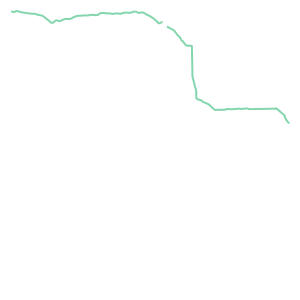

In [4]:
shn

In [5]:
path = f'{TRAFFIC_OPS_GCS}ca_transit_stops.parquet'

In [6]:
gdf = gpd.read_parquet(path)

In [7]:
gdf.columns

Index(['org_id', 'agency', 'stop_id', 'stop_name', 'n_routes',
       'route_ids_served', 'routetypes', 'n_arrivals', 'n_hours_in_service',
       'meters_to_ca_state_highway', 'base64_url', 'district_name',
       'geometry'],
      dtype='object')

In [8]:
gdf.head(3)

,org_id,agency,stop_id,stop_name,n_routes,route_ids_served,routetypes,n_arrivals,n_hours_in_service,meters_to_ca_state_highway,base64_url,district_name,geometry
0,recn8zTmGbYZv1qxV,Dumbarton Bridge Regional Operations Consortium,56414,Page Mill Rd & Peter Coutts Rd,1,DB1,3,7,5,472898.1,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,04 - Oakland,POINT (-122.15092 37.41219)
1,recn8zTmGbYZv1qxV,Dumbarton Bridge Regional Operations Consortium,56424,1501 Page Mill Rd,1,DB1,3,7,5,472980.1,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,04 - Oakland,POINT (-122.14922 37.41422)
2,recn8zTmGbYZv1qxV,Dumbarton Bridge Regional Operations Consortium,58054,1501 Page Mill Rd,1,DB1,3,7,6,472990.4,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,04 - Oakland,POINT (-122.14981 37.41397)


In [9]:
from calitp_data_analysis import geography_utils

In [10]:
gdf = gdf.query('~agency.str.contains("San Joaquin Joint")')

In [11]:
# gdf.head(10000).explore(column='meters_to_ca_state_highway')

In [12]:
gdf = gdf.to_crs(geography_utils.WGS84).pipe(
            open_data_utils.standardize_column_names
        ).pipe(
            open_data_utils.remove_internal_keys
        )

drop: []


## Test adding actual shn

In [13]:
shn_all = catalog.state_highway_network.read()[
    ["geometry"]].to_crs(geography_utils.CA_NAD83Albers_m).dissolve().geometry.iloc[0]

In [14]:
# shn_all

In [15]:
gdf.shape

(261606, 13)

In [30]:
gdf = gdf.to_crs(geography_utils.CA_NAD83Albers_m)

In [42]:
test10000 = gdf.head(10000).copy()

In [32]:
def assign_shn_dist(gdf):
    
    gdf = gdf.assign(
        meters_to_shn = gdf.geometry.distance(shn_all).round(1)
    )
    return gdf

In [33]:
((261606 / 100) * 10) / 60 #  approx minutes for plain geopandas

436.01

In [24]:
%%time

assign_shn_dist(test1000)

CPU times: user 1min 40s, sys: 585 ms, total: 1min 41s
Wall time: 1min 41s


,org_id,agency,stop_id,stop_name,n_routes,route_ids_served,routetypes,n_arrivals,n_hours_in_service,meters_to_ca_state_highway,base64_url,district_name,geometry,meters_to_shn
0,recn8zTmGbYZv1qxV,Dumbarton Bridge Regional Operations Consortium,56414,Page Mill Rd & Peter Coutts Rd,1,DB1,3,7,5,472898.1,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,04 - Oakland,POINT (-190097.461 -65006.777),1431.2
1,recn8zTmGbYZv1qxV,Dumbarton Bridge Regional Operations Consortium,56424,1501 Page Mill Rd,1,DB1,3,7,5,472980.1,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,04 - Oakland,POINT (-189942.487 -64784.884),1160.6
2,recn8zTmGbYZv1qxV,Dumbarton Bridge Regional Operations Consortium,58054,1501 Page Mill Rd,1,DB1,3,7,6,472990.4,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,04 - Oakland,POINT (-189994.567 -64811.779),1212.2
3,recn8zTmGbYZv1qxV,Dumbarton Bridge Regional Operations Consortium,58108,Page Mill Rd & Peter Coutts Rd,1,DB1,3,7,6,472905.1,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,04 - Oakland,POINT (-190153.735 -65041.126),1491.4
4,recn8zTmGbYZv1qxV,Dumbarton Bridge Regional Operations Consortium,50434,Deer Creek Rd & Arastradero Rd,1,DB1,3,10,8,471208.2,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,04 - Oakland,POINT (-189946.737 -67021.554),904.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rechaapWbeffO33OX,City and County of San Francisco,14209,40 Crestline Dr,1,37,3,45,17,518543.7,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,04 - Oakland,POINT (-215252.072 -26790.379),2313.7
996,rechaapWbeffO33OX,City and County of San Francisco,14209,40 Crestline Dr,1,37,3,45,17,518543.7,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,04 - Oakland,POINT (-215252.072 -26790.379),2313.7
997,rechaapWbeffO33OX,City and County of San Francisco,14210,74 Crestline Dr,1,37,3,45,17,518642.4,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,04 - Oakland,POINT (-215214.795 -26638.547),2444.7
998,rechaapWbeffO33OX,City and County of San Francisco,14210,74 Crestline Dr,1,37,3,45,17,518642.4,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,04 - Oakland,POINT (-215214.795 -26638.547),2444.7


In [43]:
import dask_geopandas as dg

In [44]:
ddf = dg.from_geopandas(test10000, npartitions=4)

In [45]:
ds = ddf.geometry.distance(shn_all)

In [46]:
%%time

ds.compute()

CPU times: user 20min 20s, sys: 10.4 s, total: 20min 30s
Wall time: 11min 18s


0        1431.217437
1        1160.572663
2        1212.217534
3        1491.381095
4         904.734570
            ...     
10622      29.084030
10623      89.347641
10624      28.369295
10625      16.622395
10626      31.905267
Length: 10000, dtype: float64

In [41]:
((gdf.shape[0] / 1000) * 69) / 60 #  300 minutes with Dask -- 5hrs

300.84689999999995